In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set,data_dict
import torch
import yaml
import os

# 参数设置

# 训练参数 
除了路径 其他不要变

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict()   
# TODO change the path as relative path
args.to_save_path     = r"E:\TECO_Works\Conference\ISWC2022\Run_logs"              
args.freq_save_path   = r"E:\TECO_Works\Conference\ISWC2022\Freq_data"
args.window_save_path = r"E:\TECO_Works\Conference\ISWC2022\Sliding_window"
args.root_path        = r"E:\datasets"


args.drop_transition  = False
args.datanorm_type    = "standardization" # None ,"standardization", "minmax"


args.batch_size       = 128                                                     
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.90                                           


# training setting 
args.train_epochs            = 1

args.learning_rate           = 0.001  
args.learning_rate_patience  = 5
args.learning_rate_factor    = 0.1


args.early_stop_patience     = 15

args.use_gpu                 = True if torch.cuda.is_available() else False
args.gpu                     = 0
args.use_multi_gpu           = False

args.optimizer               = "Adam"
args.criterion               = "CrossEntropy"

## 数据参数



In [3]:
args.seed                             = 1


args.data_name                        =  "dsads"

args.wavelet_filtering                = True
args.wavelet_filtering_regularization = True
args.wavelet_filtering_finetuning     = True
args.wavelet_filtering_finetuning_percent = 0.2
args.wavelet_filtering_learnable      = False


args.regulatization_tradeoff          = 0.0001
args.number_wavelet_filtering         = 10


args.difference       = False 
args.filtering        =  False
args.magnitude        =  False
args.weighted_sampler = False




args.pos_select       = None
args.sensor_select    = None


args.representation_type = "time"
args.exp_mode            = "LOCV"
if args.data_name      ==  "skodar":
    args.exp_mode            = "SOCV"
config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]

args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
args.num_classes     =  config["num_classes"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize
# input information
args.c_in            = config["num_channels"]

if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1



## 模型参数

In [4]:
args.filter_scaling_factor = 1
args.model_type              = "sahar" #"deepconvlstm"

# 实验

In [5]:
# 如果我们设置为 
args.wavelet_filtering_learnable      = False
exp = Exp(args)
import numpy as np

Use GPU: cuda:0
clone the  wavefiler weight
Wavelet Filtering Regularization
Build the sahar model!
Done!
Parameter : 458378
Set the seed as :  1


In [6]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------
================ LOCV Mode ====================
================ 8 CV ======================
================ the 0 th CV Experiment ================ 
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.00268097 0.00262467 0.0025974  0.00265252 0.00273224 0.00262467
 0.00265252 0.0026178  0.0026178  0.00263852 0.00265957 0.00268097
 0.00257069 0.0025974  0.00260417 0.0027027  0.00268097 0.00269542
 0.0026455 ]
Train data number :  7182
The number of classes is :  19
The input_length  is :  125
The channel_in is :  45
Validation data number :  798
Test data number :  1140
================ Build the model ================ 
clone the  wavefiler weight
Wavelet Filtering Regularization
Build the sahar model!
Epoch: 1 cost time: 63.53408408164978
VALI: E

KeyboardInterrupt: 

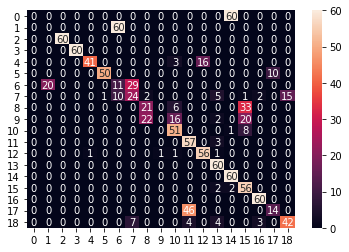

In [7]:
exp.train()